In [27]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, shape, Polygon
from owslib.wms import WebMapService
import io
from PIL import Image
import time
import overpass
import xml.etree.ElementTree as ET
import pandas as pd
import json
import geojson

In [28]:
city = "Berlin" # Muss verändert werden. um Gebiet zu Ändern
#wms_url = "https://owsproxy.lgl-bw.de/owsproxy/ows/WMS_LGL-BW_ATKIS_DOP_20_C?"
wms_url = "https://gdi.berlin.de/services/wms/dop_2021?"
wms = WebMapService(wms_url, version='1.3.0')
#layer_name = 'IMAGES_DOP_20_RGB'
layer_name = 'dop_2021'


geojson_path = f'overpass_data_{city}.geojson'
excel_path = 'category_mapping.xlsx'
mapped_geojson_path = f"mapped_data_{city}.geojson"
api = overpass.API(timeout=9999)
query = f"""      
area[name="{city}"]->.searchArea;
(
  way["roof:material"](area.searchArea);
  relation["roof:material"](area.searchArea);
);
out body;
>;
out skel qt;
"""

response = api.get(query, responseformat="xml")
with open("overpass_data.xml", mode="w") as f:
    f.write(response)
root = ET.fromstring(response)
node_coords = {}
for node in root.findall(".//node"):
    node_id = node.attrib['id']
    lat = float(node.attrib['lat'])
    lon = float(node.attrib['lon'])
    node_coords[node_id] = (lon, lat)
def convert_to_geojson(xml_root, node_coordinates):
    features = []

    for element in xml_root.findall(".//way"):
        coords = []
        for nd in element.findall(".//nd"):
            ref = nd.attrib['ref']
            if ref in node_coordinates:
                coords.append(node_coordinates[ref])
        
        if coords:
            properties = {"id": element.attrib['id']}
            for tag in element.findall(".//tag"):
                properties[tag.attrib['k']] = tag.attrib['v']

            feature = geojson.Feature(
                type="Feature",
                geometry=geojson.Polygon([coords]),
                properties=properties
            )
            features.append(feature)
    
    return geojson.FeatureCollection(features)

geojson_data = convert_to_geojson(root, node_coords)
with open(geojson_path, mode="w") as f:
    geojson.dump(geojson_data, f)

In [29]:
def is_valid_polygon(geometry):
    try:
        poly = shape(geometry)
        if poly.is_valid and isinstance(poly, Polygon):
            return poly
    except (ValueError, KeyError, IndexError):
        return None
    return None

with open(geojson_path) as f:
    data = json.load(f)
valid_features = [feature for feature in data['features'] if is_valid_polygon(feature['geometry'])]
properties = [feature['properties'] for feature in valid_features]
geometries = [shape(feature['geometry']) for feature in valid_features]
gdf = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")
mapping_df = pd.read_excel(excel_path, header=None, names=['original', 'mapped'])
mapping_dict = mapping_df[mapping_df['mapped'] != 'x'].set_index('original')['mapped'].to_dict()
gdf['mapped_roof_material'] = gdf['roof:material'].map(mapping_dict)
gdf = gdf.dropna(subset=['mapped_roof_material'])
geojson_data = gdf.to_json()
with open(mapped_geojson_path, mode="w") as f:
    f.write(geojson_data)


In [30]:
# === Parameter ===
grid_spacing = 100                           # Seitenlänge der Quadrate (in EPSG 25833 in Metern)
output_dir = "atlas_bilder/"     # Zielordner für die Bilder
category_attribute = "mapped_roof_material"         

#Farbmapping der Polygone nach Material
color_mapping = {
    "roof_tiles": "#0bfbff",
    "metal": "#ff33dd",
    "concrete": "#04ff00",
    "tar_paper": "#f2ff00",
}

# === Schritt 1: GeoJSON-Layer laden und Styling definieren ===
polygons_gdf = gpd.read_file(mapped_geojson_path)
if polygons_gdf.empty:
    raise Exception("Die GeoJSON-Datei konnte nicht geladen werden oder ist leer.")
polygons_gdf = polygons_gdf.to_crs("EPSG:25832")

#nicht definierte Kategorien erhalten "black", um unsichtbar zu sein
polygons_gdf["color"] = polygons_gdf[category_attribute].map(lambda cat: color_mapping.get(cat, "black"))

In [31]:


# === Schritt 2: Quadratgrid über den Extent der Polygon-Features erstellen ===
def create_grid(gdf, grid_size):
    """Erstellt ein Grid (als Liste von Shapely-Polygonen) über den Gesamt-Extent des GeoDataFrame."""
    minx, miny, maxx, maxy = gdf.total_bounds
    cells = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            cells.append(box(x, y, x + grid_size, y + grid_size))
            y += grid_size
        x += grid_size
    return cells

grid_cells = create_grid(polygons_gdf, grid_spacing)
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=polygons_gdf.crs)


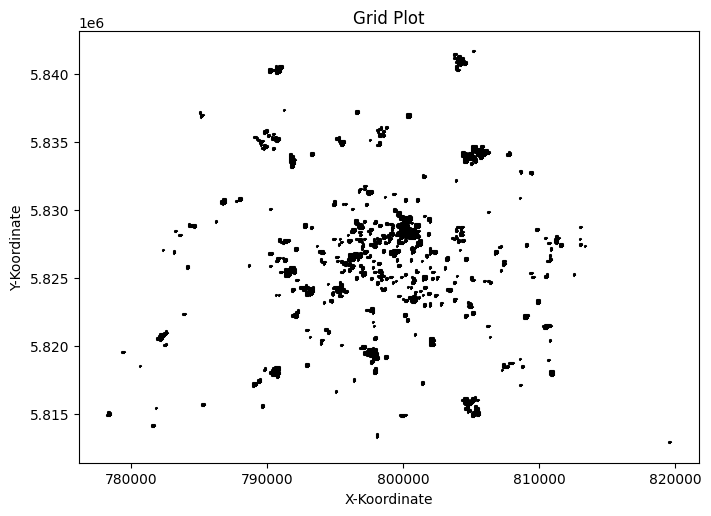

In [32]:
# === Schritt 3: Filterung des Grids (nur Quadrate, die mit mindestens einem Polygon überschneiden) ===
# Es wird für jedes Grid-Element geprüft, ob es sich mit einem der Polygone schneidet.
grid_gdf['intersects'] = grid_gdf.geometry.apply(lambda cell: polygons_gdf.intersects(cell).any())
filtered_grid_gdf = grid_gdf[grid_gdf['intersects']].copy()
filtered_grid_gdf = filtered_grid_gdf.drop(columns='intersects')
fig, ax = plt.subplots(figsize=(8, 8))
filtered_grid_gdf.boundary.plot(ax=ax, color='black')
ax.set_title("Grid Plot")
ax.set_xlabel("X-Koordinate")
ax.set_ylabel("Y-Koordinate")
plt.show()


In [33]:

# === Schritt 4: Atlas-Export – Erstellen von Bildern für jedes gültige Grid-Quadrat ===
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir+"/masks", exist_ok=True)
os.makedirs(output_dir+"/satellites", exist_ok=True)
for idx, row in filtered_grid_gdf.iterrows():
    cell = row.geometry
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    # Ansichtsfenster definieren: Bereich des Grid-Quadrats, optional mit einem kleinen Puffer
    """margin_x = (cell.bounds[2] - cell.bounds[0]) * 0.1
    margin_y = (cell.bounds[3] - cell.bounds[1]) * 0.1
    ax.set_xlim(cell.bounds[0] - margin_x, cell.bounds[2] + margin_x)
    ax.set_ylim(cell.bounds[1] - margin_y, cell.bounds[3] + margin_y)"""
    ax.set_xlim(cell.bounds[0], cell.bounds[2])
    ax.set_ylim(cell.bounds[1], cell.bounds[3])
    
    intersecting_polygons = polygons_gdf[polygons_gdf.intersects(cell)]
    for category, group in intersecting_polygons.groupby(category_attribute):
        group.plot(ax=ax, color=color_mapping.get(category, "grey"), edgecolor=color_mapping.get(category, "grey"))
    ax.axis('off')
    output_path = os.path.join(output_dir+"masks", f"{city}_atlas_page_{idx+1}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor())
    plt.close(fig)
    img = Image.open(output_path)
    img_resized = img.resize((512, 512), Image.LANCZOS)
    img_resized.save(output_path)

print("Atlas-Export abgeschlossen. Die Bilder wurden gespeichert.")

Atlas-Export abgeschlossen. Die Bilder wurden gespeichert.


In [ ]:

# Für jedes gültige Grid-Quadrat eine WMS-Anfrage stellen
for idx, row in filtered_grid_gdf.iterrows():
    time.sleep(0.1)
    cell = row.geometry
    bbox = cell.bounds
    width, height = 512, 512   
    response = wms.getmap(
        layers=[layer_name],
        styles=[''],
        srs='EPSG:25832',
        bbox=bbox,
        size=(width, height),
        format='image/png',
        transparent=True
    )  
    img = Image.open(io.BytesIO(response.read()))  
    output_path_wms = os.path.join(output_dir+"satellites", f"{city}_atlas_page_{idx+1}_wms.png")
    img.save(output_path_wms)